# Celeb-DF-v2 Dataset Sampling


This notebook is used to sample the full [Celeb-DF-v2](https://github.com/yuezunli/celeb-deepfakeforensics) dataset for deepfake detection research purposes. Sample data of 100 deepfakes and 100 real videos are extracted to be 100 frames for each video, resulting in a total of 20,000 frames of image.


In [1]:
import os
import csv
import random
import shutil
import cv2
import matplotlib.pyplot as plt

In [12]:
DATASET_DIR = "/mnt/e/datasets/Celeb-DF-v2"
CELEB_REAL_DIR = os.path.join(DATASET_DIR, "Celeb-real")
CELEB_SYNTHESIS_DIR = os.path.join(DATASET_DIR, "Celeb-synthesis")

SAMPLE_DIR = "/mnt/e/samples/videos/Celeb-DF-v2"
SAMPLE_DEEPFAKE_DIR = os.path.join(SAMPLE_DIR, "Deepfake")
SAMPLE_ORIGINAL_VID_DIR = os.path.join(SAMPLE_DIR, "Original")

SAMPLE_FRAMES_DIR = "/mnt/e/samples/videos/Celeb-DF-v2"
SAMPLE_FRAMES_DEEPFAKE_DIR = os.path.join(SAMPLE_DIR, "Deepfake")
SAMPLE_FRAMES_ORIGINAL_VID_DIR = os.path.join(SAMPLE_DIR, "Original")

SAMPLE_LIST_PATH = "celeb-df-v2-list.csv"

SAMPLE_SIZE = 100
EXTRACTED_FRAME_SIZE = 100

## Video Sampling


### Sample Real Videos

Real videos are sampled based on deepfakes' original videos. The original video file for each deepfake are retrieved from the deepfake filename.


#### Extract original vids filename for each deepfake from its filename


In [4]:
def extract_original_deepfake_filename(deepfake_filename):
    splitted = deepfake_filename.split("_")
    return f"{splitted[0]}_{splitted[-1]}"

In [5]:
deepfakes = os.listdir(CELEB_SYNTHESIS_DIR)
deepfake_original_vids = list(map(extract_original_deepfake_filename, deepfakes))

for i in range(0, 5):
    print(f"Deepfake: {deepfakes[i]} => Original: {deepfake_original_vids[i]}")
print("...")

Deepfake: id0_id16_0000.mp4 => Original: id0_0000.mp4
Deepfake: id0_id16_0001.mp4 => Original: id0_0001.mp4
Deepfake: id0_id16_0002.mp4 => Original: id0_0002.mp4
Deepfake: id0_id16_0003.mp4 => Original: id0_0003.mp4
Deepfake: id0_id16_0004.mp4 => Original: id0_0004.mp4
...


#### Get unique deepfake original vids


In [6]:
unique_deepfake_original_vids = list(set(deepfake_original_vids))
print(
    f"Found {len(unique_deepfake_original_vids)} unique original videos for each deepfakes"
)

Found 542 unique original videos for each deepfakes


#### Sample unique deepfake original vids


In [7]:
sample_original_vids = random.sample(unique_deepfake_original_vids, SAMPLE_SIZE)
print(f"Sampled {len(sample_original_vids)} original video files")

Sampled 100 original video files


### Sample Deepfakes

Each deepfake sample is chosen by a random choice of some deepfakes generated based on the original video samples.


In [8]:
def match_deepfake_original_vid_filename(deepfake_filename, original_vid_filename):
    if extract_original_deepfake_filename(deepfake_filename) == original_vid_filename:
        return deepfake_filename

In [9]:
sample_deepfakes = []
for original_vid_filename in sample_original_vids:
    original_vid_deepfakes = list(
        filter(
            lambda deepfake_filename: match_deepfake_original_vid_filename(
                deepfake_filename, original_vid_filename
            ),
            deepfakes,
        )
    )
    sample_deepfakes.append(random.choice(original_vid_deepfakes))

print(
    f"Sampled {len(sample_deepfakes)} deepfake files based on the sample original videos"
)

Sampled 100 deepfake files based on the sample original videos


### Define Each Sample's File Path


In [15]:
sample_original_vid_files = list(
    map(lambda filename: os.path.join(CELEB_REAL_DIR, filename), sample_original_vids)
)
sample_deepfake_files = list(
    map(lambda filename: os.path.join(CELEB_SYNTHESIS_DIR, filename), sample_deepfakes)
)

### Copy Sample to a Separate Directory


In [18]:
for file_path in sample_original_vid_files:
    if os.path.isfile(file_path):
        shutil.copy(file_path, SAMPLE_ORIGINAL_VID_DIR)

In [19]:
for file_path in sample_deepfake_files:
    if os.path.isfile(file_path):
        shutil.copy(file_path, SAMPLE_DEEPFAKE_DIR)

### Create CSV File to List Sample Video Files


In [20]:
with open(SAMPLE_LIST_PATH, "w", newline="") as sample_list_file:
    header = ["file", "label"]
    writer = csv.writer(sample_list_file)
    writer.writerow(header)

    for filename in sample_deepfake_files:
        dataset_path = filename.split("/")[-3:]
        writer.writerow(["/".join(dataset_path), "deepfake"])

    for filename in sample_original_vid_files:
        dataset_path = filename.split("/")[-3:]
        writer.writerow(["/".join(dataset_path), "real"])

## Extract Sample Video Frames


### Extract Deepfakes and Real Vids Frames


In [21]:
def extract_frames(video_path, output_dir, num_frames=100):
    cap = cv2.VideoCapture(video_path)

    num_frames_total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if num_frames_total <= num_frames:
        frame_interval = 1
    else:
        frame_interval = int(num_frames_total / num_frames)

    frames = []
    count = 1

    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        if count % frame_interval == 0:
            frames.append(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
            filename, _ = os.path.splitext(video_path)
            filename = filename.split("/")[-1]
            frame_count = int(count / frame_interval)
            cv2.imwrite(
                os.path.join(output_dir, f"{filename}-{frame_count}.jpg"),
                frame,
            )

            if frame_count == 100:
                break

        count += 1

    cap.release()

In [118]:
for filename in os.listdir(SAMPLE_ORIGINAL_VID_DIR):
    file_path = os.path.join(SAMPLE_ORIGINAL_VID_DIR, filename)
    extract_frames(file_path, SAMPLE_FRAMES_ORIGINAL_VID_DIR)

In [22]:
for filename in os.listdir(SAMPLE_DEEPFAKE_DIR):
    file_path = os.path.join(SAMPLE_DEEPFAKE_DIR, filename)
    extract_frames(file_path, SAMPLE_FRAMES_DEEPFAKE_DIR)

### Preview Extracted Video Frames


In [23]:
NUM_PREVIEW_IMAGES = 20
NUM_ROWS = 5
NUM_COLS = NUM_PREVIEW_IMAGES // NUM_ROWS

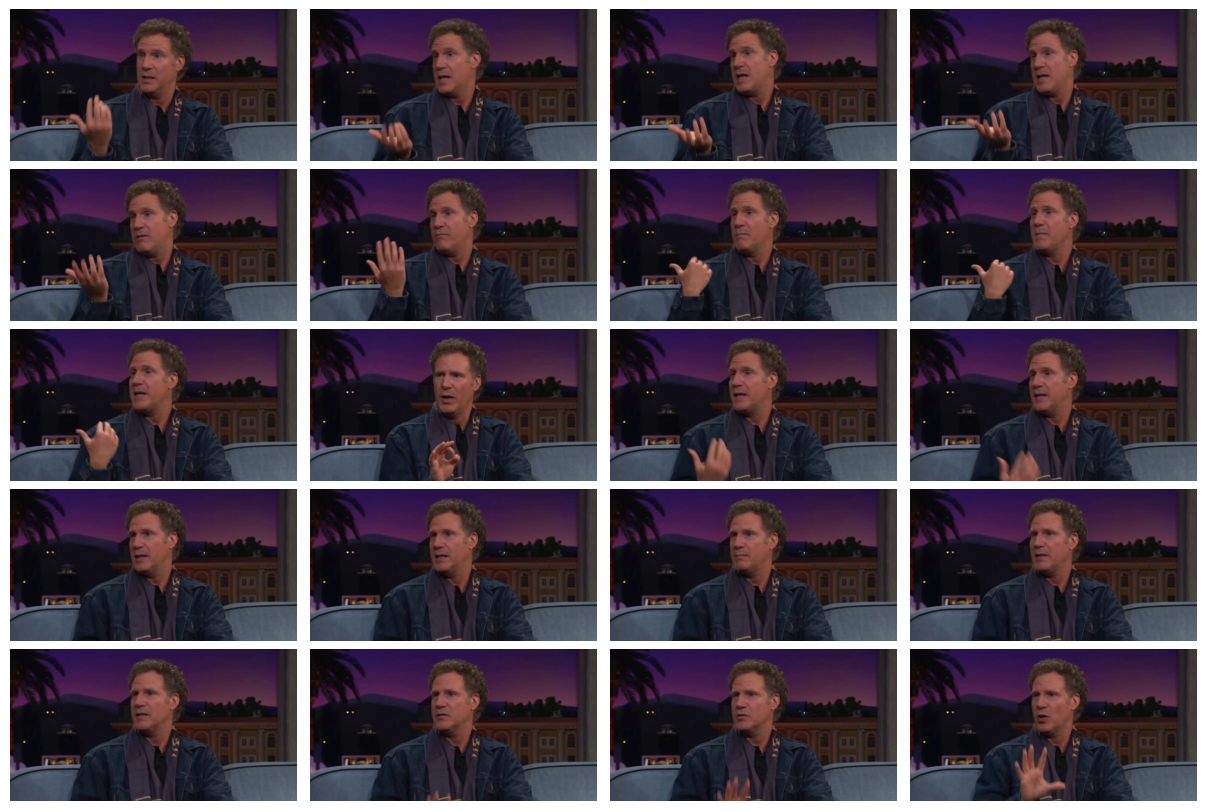

In [28]:
frame_files = [
    os.path.join(SAMPLE_FRAMES_DEEPFAKE_DIR, filename)
    for filename in os.listdir(SAMPLE_FRAMES_DEEPFAKE_DIR)[-NUM_PREVIEW_IMAGES:]
]

fig, axs = plt.subplots(NUM_ROWS, NUM_COLS, figsize=(12, 8), constrained_layout=True)
for i, ax in enumerate(axs.flatten()):
    img = plt.imread(frame_files[i])
    ax.imshow(img)
    ax.axis("off")

plt.show()